In [26]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from IPython.display import display
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [27]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

clip_model = clip_model.to(device)

In [28]:
def process_text(text):
    inputs = clip_processor(
        text=text,
        return_tensors="pt"
    )
    
    for key in inputs.keys():
        inputs[key] = inputs[key].to(device)
    
    text_features = clip_model.get_text_features(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask)

    return text_features

In [30]:
def get_images(text_query, folder_name):
    text_features = process_text(text_query)
    
    top_images = []
    total_files = sum(len(files) for _, _, files in os.walk("image_embeddings"))
    with tqdm(total=total_files, desc="Searching files") as pbar:
        for root, dirs, files in os.walk("image_embeddings"):
            for file in files:
                if file.endswith('.pt'):
                    image_embedding = torch.load(os.path.join(root, file)).to(device)
                    similarity_score = torch.nn.functional.cosine_similarity(image_embedding, text_features)
                    
                    if len(top_images) < 3:
                        top_images.append((os.path.join(root, file), similarity_score.item()))
                        top_images.sort(key=lambda x: x[1], reverse=True)
                    else:
                        min_score_index = min(range(len(top_images)), key=lambda i: top_images[i][1])
                        if similarity_score > top_images[min_score_index][1]:
                            top_images[min_score_index] = (os.path.join(root, file), similarity_score.item())
                            top_images.sort(key=lambda x: x[1], reverse=True)
                    
                    pbar.update(1)  # Update progress bar
                    
    result_images = []
    for image_path, score in top_images:
        result_images.append((image_path, Image.open(image_path.replace('.pt', '').replace('image_embeddings', folder_name)), score))
    
    return result_images

Searching files: 100%|███████████████████████| 130/130 [00:00<00:00, 445.37it/s]


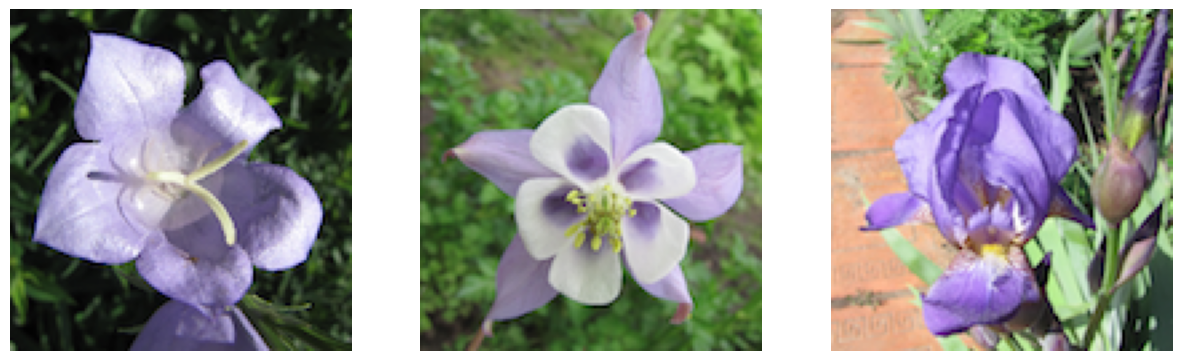

In [33]:
top_images = get_images("Blue Flower", folder_name="MiniData/")

if top_images:
    fig, axes = plt.subplots(1, len(top_images), figsize=(15, 5))
    for i, (image_path, image, similarity_score) in enumerate(top_images):
        axes[i].imshow(image)
        axes[i].axis('off')
    plt.show()
else:
    print("No matching images found.")